# computing correlation matrix between 3D classes and frames of the MD trajectory

## making an ensemble of structures and aligning them to the first volume
This part of the script pulls 50 structures from the pdb_dir that stores the pdb file frames of the MD trajectory and bundles them in a single .pdb file. Then the ensemble can be aligned to the first 3D class in ChimeraX by using the "fit volume" tool.

From the aligned ensemble, a mask should be made in ChimeraX using the molmap command.

In [27]:
# imports
import os
import numpy as np
import gemmi
import mrcfile
import warnings

from tqdm import tqdm
from emmer.pdb.convert.convert_pdb_to_map import convert_pdb_to_map
from emmer.ndimage.filter.low_pass_filter import low_pass_filter


In [28]:
# functions
def filter_gemmi_model(model_gemmi, remove_sidechains=False):
    # remove ligand residues and all sidechain atoms
    list_of_residue_names = [
        "F2A", "H2A", "NLM", "NM5", "NM7", "NME"
    ]
    new_model_gemmi = gemmi.Model(model_gemmi.name)
    for chn in model_gemmi:
        new_chain_gemmi = gemmi.Chain(chn.name)
        for res in chn:
            if res.name not in list_of_residue_names:
                new_res_gemmi = gemmi.Residue()
                new_res_gemmi.name = res.name
                
                if remove_sidechains:
                    for atm in res:
                        if atm.name == "CA":
                            new_atm_gemmi = gemmi.Atom()
                            new_atm_gemmi.name = atm.name
                            new_atm_gemmi.pos = atm.pos
                            new_atm_gemmi.element = gemmi.Element(atm.element.name)
                            new_res_gemmi.add_atom(new_atm_gemmi)

                else:
                    for atm in res:
                        new_atm_gemmi = gemmi.Atom()
                        new_atm_gemmi.name = atm.name
                        new_atm_gemmi.pos = atm.pos
                        new_atm_gemmi.element = gemmi.Element(atm.element.name)
                        new_res_gemmi.add_atom(new_atm_gemmi)                  

                new_chain_gemmi.add_residue(new_res_gemmi)
        new_model_gemmi.add_chain(new_chain_gemmi)
    return new_model_gemmi

# functions
def compute_correlation(modelmap, targetmap, mask):
    """Compute the correlation between two maps"""
    
    warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in scalar divide")
    # apply mask to both maps
    modelmap_masked = modelmap * mask
    targetmap_masked = targetmap * mask
    # compute the mean of the two maps
    mean_modelmap = np.mean(modelmap_masked)
    mean_targetmap = np.mean(targetmap_masked)
    # compute the standard deviation of the two maps
    std_modelmap = np.std(modelmap_masked)
    std_targetmap = np.std(targetmap_masked)
    # compute the correlation
    correlation = np.mean((modelmap_masked - mean_modelmap) * (targetmap_masked - mean_targetmap)) / (std_modelmap * std_targetmap)
    return correlation


In [4]:
project_dir = "/home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/DESRES-Trajectory_sarscov2-11021566-11021571-mixed"
pdb_dir = "/home/mjoosten1/projects/roodmus/data/DE-Shaw_covid_spike_protein/mnt/parakeet_storage4/ConformationSampling/DESRES-Trajectory_sarscov2-11021566-11021571-mixed"
output_dir = os.path.join(project_dir, "aligned_ensembles")

pdb_files = [os.path.join(pdb_dir, f) for f in os.listdir(pdb_dir) if f.endswith(".pdb")]
split_1 = [f for f in pdb_files if int(f.strip(".pdb").split("_")[-1]) <= 8334]
split_2 = [f for f in pdb_files if int(f.strip(".pdb").split("_")[-1]) > 8334]

N = 25
# sample N files from the total number of files, evenly spaced
split_1_sample = split_1[::int(np.ceil(len(split_1)/N))]
split_2_sample = split_2[::int(np.ceil(len(split_2)/N))]

ensemble_gemmi = gemmi.Structure()
ensemble_gemmi_CA = gemmi.Structure()
for filename in split_1_sample:
    pdb_path = os.path.join(pdb_dir, filename)
    frame_gemmi = gemmi.read_structure(pdb_path)
    frame_gemmi_filtered = filter_gemmi_model(frame_gemmi[0], remove_sidechains=False)
    ensemble_gemmi.add_model(frame_gemmi_filtered)
    frame_gemmi_filtered_CA = filter_gemmi_model(frame_gemmi[0], remove_sidechains=True)
    ensemble_gemmi_CA.add_model(frame_gemmi_filtered_CA)

# write the ensemble to a pdb file
ensemble_gemmi.write_pdb(os.path.join(output_dir, "ensemble_closed_state.pdb"))
ensemble_gemmi_CA.write_pdb(os.path.join(output_dir, "ensemble_closed_state_CA.pdb"))

ensemble_gemmi = gemmi.Structure()
ensemble_gemmi_CA = gemmi.Structure()
for filename in split_2_sample:
    pdb_path = os.path.join(pdb_dir, filename)
    frame_gemmi = gemmi.read_structure(pdb_path)
    frame_gemmi_filtered = filter_gemmi_model(frame_gemmi[0], remove_sidechains=False)
    ensemble_gemmi.add_model(frame_gemmi_filtered)
    frame_gemmi_filtered_CA = filter_gemmi_model(frame_gemmi[0], remove_sidechains=True)
    ensemble_gemmi_CA.add_model(frame_gemmi_filtered_CA)

# write the ensemble to a pdb file
ensemble_gemmi.write_pdb(os.path.join(output_dir, "ensemble_open_state.pdb"))
ensemble_gemmi_CA.write_pdb(os.path.join(output_dir, "ensemble_open_state_CA.pdb"))


## compute modelmaps for each frame of the aligned ensmebles

In [6]:
# define the data for each classification run
# 2 class data set
classes_data = {
    "2_classes": {
        "class1": {
            "job": "job044",
            "map": "run_class001.mrc",
        },
        "class2": {
            "job": "job050",
            "map": "run_class001.mrc",
        },
    },
    "3_classes": {
        "class1": {
            "job": "job018",
            "map": "run_class001.mrc",
        },
        "class2": {
            "job": "job031",
            "map": "run_class001.mrc",
        },
        "class3": {
            "job": "job032",
            "map": "run_class001.mrc",
        },
    },
    "10_classes": {
        "class1": {
            "job": "job093",
            "map": "run_class001.mrc",
            "resolution": 3,
        },
        "class2": {
            "job": "job094",
            "map": "run_class001.mrc",
            "resolution": 3,
        },
        "class3": {
            "job": "job095",
            "map": "run_class001.mrc",
            "resolution": 3,
        },
        "class4": {
            "job": "job096",
            "map": "run_class001.mrc",
            "resolution": 3,
        },
        "class5": {
            "job": "job097",
            "map": "run_class001.mrc",
            "resolution": 3,
        },
        "class6": {
            "job": "job098",
            "map": "run_class001.mrc",
            "resolution": 3,
        },
        "class7": {
            "job": "job099",
            "map": "run_class001.mrc",
            "resolution": 3,
        },
        "class8": {
            "job": "job100",
            "map": "run_class001.mrc",
            "resolution": 3,
        },
        "class9": {
            "job": "job101",
            "map": "run_class001.mrc",
            "resolution": 3,
        },
        "class10": {
            "job": "job102",
            "map": "run_class001.mrc",
            "resolution": 3,
        },
    },
}

In [34]:
open_ensemble = os.path.join(project_dir, "aligned_ensembles", "ensemble_open_state_aligned.pdb")
closed_ensemble = os.path.join(project_dir, "aligned_ensembles", "ensemble_closed_state_aligned.pdb")
open_map = os.path.join(project_dir, "aligned_ensembles", "ensemble_open_modelmap.mrc")
closed_map = os.path.join(project_dir, "aligned_ensembles", "ensemble_closed_modelmap.mrc")

resolution = 3
for classification_job in ["2_classes", "3_classes", "10_classes"]:
    n_classes = len(classes_data[classification_job])

    # load the class maps
    for class_name, class_data in classes_data[classification_job].items():
        class_map = os.path.join(project_dir, "Refine3D", class_data["job"], class_data["map"])
        classes_data[classification_job][class_name]["map_data"] = mrcfile.open(class_map).data

# get the gemmi structure of the first class
class1_gemmi = gemmi.read_ccp4_map(os.path.join(project_dir, "Refine3D", classes_data[classification_job]["class1"]["job"], classes_data[classification_job]["class1"]["map"]))
unitcell = class1_gemmi.grid.unit_cell
size = class1_gemmi.grid.shape
vsize = class1_gemmi.grid.spacing[0]

# load the ensemble modelmaps and threshold them at 2sigma below the mean
open_map_mrc = mrcfile.open(open_map)
closed_map_mrc = mrcfile.open(closed_map)
threshold_open = np.mean(open_map_mrc.data) + 1 * np.std(open_map_mrc.data)
threshold_closed = np.mean(closed_map_mrc.data) + 2 * np.std(closed_map_mrc.data)

# print(f"mean of open map: {np.mean(open_map_mrc.data)}")
# print(f"mean of closed map: {np.mean(closed_map_mrc.data)}")
# print(f"threshold of open map: {threshold_open}")
# print(f"threshold of closed map: {threshold_closed}")

open_mask = open_map_mrc.data > threshold_open
closed_mask = closed_map_mrc.data > threshold_closed

# load the ensembles
ensemble_open_gemmi = gemmi.read_structure(open_ensemble)
ensemble_closed_gemmi = gemmi.read_structure(closed_ensemble)
n_frames = len(ensemble_open_gemmi) + len(ensemble_closed_gemmi)

modelmaps_open = []
for frame_model in tqdm(ensemble_open_gemmi):
    frame_gemmi = gemmi.Structure()
    frame_gemmi.add_model(frame_model)
    map_from_model_unfiltered = convert_pdb_to_map(
        input_pdb=frame_gemmi,
        unitcell=unitcell,
        size=size,
        return_grid=False,
    )
    map_from_model_zyx = low_pass_filter(
        map_from_model_unfiltered, resolution, vsize
    )
    map_from_model = np.rot90(
        np.flip(map_from_model_zyx, axis=0), axes=(2, 0)
    )
    modelmaps_open.append(map_from_model)

modelmaps_closed = []
for frame_model in tqdm(ensemble_closed_gemmi):
    frame_gemmi = gemmi.Structure()
    frame_gemmi.add_model(frame_model)
    map_from_model_unfiltered = convert_pdb_to_map(
        input_pdb=frame_gemmi,
        unitcell=unitcell,
        size=size,
        return_grid=False,
    )
    map_from_model_zyx = low_pass_filter(
        map_from_model_unfiltered, resolution, vsize
    )
    map_from_model = np.rot90(
        np.flip(map_from_model_zyx, axis=0), axes=(2, 0)
    )
    modelmaps_closed.append(map_from_model)

100%|██████████| 25/25 [12:14<00:00, 29.37s/it]


In [37]:
# compute the correlation
for classification_job in ["2_classes", "3_classes", "10_classes"]:
    print(f"Computing correlation matrix for {classification_job}")
    n_classes = len(classes_data[classification_job])
    correlation_matrix = np.zeros((n_frames, n_classes))
    for i, modelmap in enumerate(tqdm(modelmaps_open)):
        for j, class_name in enumerate(classes_data[classification_job].keys()):
            correlation_matrix[i, j] = compute_correlation(modelmap, classes_data[classification_job][class_name]["map_data"], open_mask)

    for i, modelmap in enumerate(tqdm(modelmaps_closed)):
        for j, class_name in enumerate(classes_data[classification_job].keys()):
            correlation_matrix[i+len(modelmaps_open), j] = compute_correlation(modelmap, classes_data[classification_job][class_name]["map_data"], closed_mask)

    # save the correlation matrix as a .npy file in the aligned_ensembles directory
    np.save(os.path.join(project_dir, "aligned_ensembles", f"correlation_matrix_{classification_job}.npy"), correlation_matrix)
        

Computing correlation matrix for 2_classes


100%|██████████| 25/25 [01:05<00:00,  2.64s/it]


Computing correlation matrix for 3_classes


100%|██████████| 25/25 [01:39<00:00,  3.97s/it]


Computing correlation matrix for 10_classes


100%|██████████| 25/25 [05:25<00:00, 13.04s/it]


0.3674143905601764


Text(-0.65, 12, 'open state')

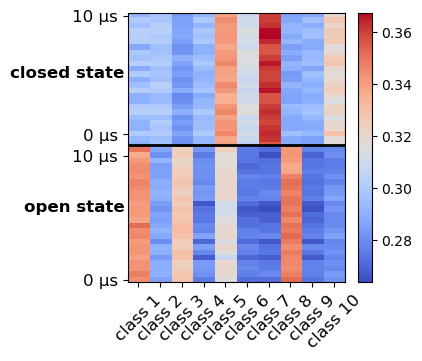

In [36]:
import matplotlib.pyplot as plt
print(correlation_matrix.max())
fig, ax = plt.subplots(figsize=(3.5, 3.5))
# show the heatmap as a square (~50x3)
ax.imshow(correlation_matrix, cmap="coolwarm", aspect="auto", origin="lower")
ticklabels = [f"class {i+1}" for i in range(n_classes)]
ax.set_xticks(range(n_classes))
ax.set_xticklabels(ticklabels, fontsize=12, rotation=45)
ax.set_yticks([0, n_frames//2-2, n_frames//2+2, n_frames-1])
ax.set_yticklabels(["0 \u03BCs", "10 \u03BCs", "0 \u03BCs", "10 \u03BCs"], fontsize=12)
ax.axhline(y=n_frames//2, color="black", linestyle="solid", linewidth=2)
# add colorbar
cbar = ax.figure.colorbar(ax.get_images()[0], ax=ax, orientation="vertical")
ax.text(
    -0.65,
    3*n_frames//4,
    "closed state",
    ha='right',
    va='bottom',
    fontsize=12,
    fontweight='bold',
)
ax.text(
    -0.65,
    n_frames//4,
    "open state",
    ha='right',
    va='bottom',
    fontsize=12,
    fontweight='bold',
)

# save the figure
# fig.savefig(os.path.join(project_dir, "figures", f"correlation_matrix_{n_classes}classes.pdf"), bbox_inches="tight")